In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers

2023-07-25 21:10:36.598591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 21:10:37.666971: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student1/openssl/lib:
2023-07-25 21:10:37.667081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student1/openssl/lib:
2023-07-25 21:10:37.667094: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
batch_size = 100
img_height = 250
img_width = 250

In [3]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


2023-07-25 21:10:47.814730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 21:10:48.533639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [4]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
import keras_lmu
import tensorflow as tf
from keras import layers

img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

# LMU layer
lmu_layer = keras_lmu.LMU(
    memory_d=1,
    order=256,
    theta=784,
    hidden_cell=tf.keras.layers.SimpleRNNCell(units=128),
    trainable_theta=True,
    return_sequences=False,  # Only return the last output in the output sequence
)

model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Reshape((-1, 128)),  # reshape for LMU
    lmu_layer,  # LMU replaces Flatten
    layers.Dense(len(class_names), activation= 'softmax')  # final classification layer
])

2023-07-25 21:12:23.498741: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1a5ac580


In [6]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 10)

Epoch 1/10


2023-07-25 21:12:43.740440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-07-25 21:12:44.887244: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe75001b850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-25 21:12:44.887309: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-25 21:12:44.899774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-25 21:12:45.274871: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 [==============================] - 15s 484ms/step - loss: 0.6746 - accuracy: 0.5601 - val_loss: 0.5666 - val_accuracy: 0.6939
Epoch 2/10
8/8 [==============================] - 1s 171ms/step - loss: 0.6137 - accuracy: 0.6612 - val_loss: 0.4762 - val_accuracy: 0.8367
Epoch 3/10
8/8 [==============================] - 1s 172ms/step - loss: 0.3501 - accuracy: 0.8319 - val_loss: 0.5033 - val_accuracy: 0.7551
Epoch 4/10
8/8 [==============================] - 1s 171ms/step - loss: 0.1825 - accuracy: 0.9330 - val_loss: 0.1600 - val_accuracy: 0.9388
Epoch 5/10
8/8 [==============================] - 1s 171ms/step - loss: 0.0843 - accuracy: 0.9659 - val_loss: 0.3153 - val_accuracy: 0.8776
Epoch 6/10
8/8 [==============================] - 1s 172ms/step - loss: 0.0728 - accuracy: 0.9798 - val_loss: 0.1726 - val_accuracy: 0.9082
Epoch 7/10
8/8 [==============================] - 1s 172ms/step - loss: 0.0689 - accuracy: 0.9836 - val_loss: 0.2084 - val_accuracy: 0.9388
Epoch 8/10
8/8 [==============

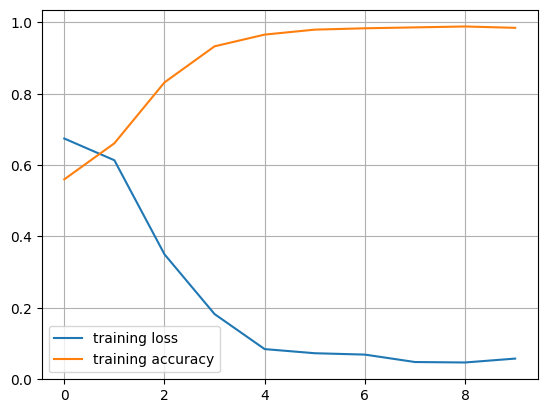

In [8]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

In [9]:
# final accuracy on test set
model.evaluate(testing_ds)

1/1 [==============================] - 0s 250ms/step - loss: 0.3015 - accuracy: 0.9300


[0.30151623487472534, 0.9300000071525574]